# Mesenchymal lineage - Seurat analysis

Please, save the anndata object as follows

```
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is not log
```


In [1]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)


luz_colors = c('#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')


colors = c(luz_colors, '#db7293', 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /home/jovyan/my-conda-envs/R_Seurat3/lib/libblas.so.3.8.0
LAPACK: /home/jovyan/my-conda-envs/R_Seurat3/lib/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.5        Seurat_3.

In [94]:
markers = list( 'Fetal Leydig' = c('FDX1','GLI1',  'HHIP', 'INSL3', 'PTCH1', 'PTCH2'),
                'Steroidogenic' = c('CYP17A1', 'HSD3B2',  'GSTA3', 'TM7SF2'),
                'ExM' = c('ACTA2', 'FN1', 'MDFI', 'MFAP4', 'NID1')
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Process with Seurat from raw

In [12]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = '/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')
allgenes = rownames(anndata)
anndata

Warning message:
“Functionality for reading and writing H5AD files is being moved to SeuratDisk
For more details, please see https://github.com/mojaveazure/seurat-disk
and https://mojaveazure.github.io/seurat-disk/index.html”
Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
28230 features across 319081 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

In [17]:
# Add metadata
meta = read.csv('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.csv', stringsAsFactors = F)
names(meta)[1] = 'index'
anndata@meta.data$is_doublet = meta$is_doublet[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$clusters = meta$clusters_manual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$PCW = meta$PCW[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
anndata@meta.data$sex = meta$sex[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$process = meta$process[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$individual = meta$individual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$sample_source = meta$sample_source[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$scrublet_cluster_score = meta$scrublet_cluster_score[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)

In [18]:
table(anndata@meta.data$clusters)


               Coel Epi                Doublets             Endothelial 
                   2576                    2756                    5623 
             Epithelial               Erythroid              Germ cells 
                   2403                    3383                    2704 
                 Immune                   lowQC Mesenchymal_GATA2_NR2F1 
                   3215                    9451                   33548 
   Mesenchymal_LHX9_ARX             Metanephros                  Neural 
                  33064                     448                    1491 
                     PV                 Sertoli       Supporting_female 
                   2112                   37393                    3992 

In [19]:
# subset datasets to contain clusters of interest and remove doublets
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, sex %in% 'male')))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata

An object of class Seurat 
28230 features across 144159 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

In [20]:
table(anndata@meta.data$clusters)


               Coel Epi                Doublets             Endothelial 
                   2576                    2756                    5623 
             Epithelial               Erythroid              Germ cells 
                   2403                    3383                    2704 
                 Immune                   lowQC Mesenchymal_GATA2_NR2F1 
                   3215                    9451                   33548 
   Mesenchymal_LHX9_ARX             Metanephros                  Neural 
                  33064                     448                    1491 
                     PV                 Sertoli       Supporting_female 
                   2112                   37393                    3992 

In [23]:
# Add SEX metadata
meta_f = read.csv('/nfs/team292/lg18/with_valentina/supporting_nocycling_annotation.csv', stringsAsFactors = F)
meta_m = read.csv('/nfs/team292/lg18/with_valentina/mesenchymal_annotated.csv', stringsAsFactors = F)

anndata@meta.data$clusters_lineages = 'new'
anndata@meta.data$clusters_lineages[ rownames(anndata@meta.data) %in% meta_m$X ] = 
meta_m$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_m$X], meta_m$X) ]
anndata@meta.data$clusters_lineages[ rownames(anndata@meta.data) %in% meta_f$X ] = 
meta_f$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_f$X], meta_f$X) ]
table(anndata@meta.data$clusters_lineages)

# Remove lowQC and doublets
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data,  clusters_lineages %in% 
                                                  c('FetalLeydig-like', 
                                                      'FetalLeydig') )))

table(anndata@meta.data$clusters_lineages)


         coelEpi      FetalLeydig FetalLeydig-like               Gi 
            2162             2237              381             9708 
          M_ALX1        M_cycling            M_MGP M_MullDuct_AMHR2 
            1552             8590            11465              791 
 M_MullDuct_LGR5      M_prog_ISL1              new               Oi 
             171             1375            49776              825 
     ovarianSurf     preGC_I_OSR1         preGC_II preGC_II_hypoxia 
              58                2               24                2 
         Sertoli      Sertoli_low    Sertoli_WFDC2           sKITLG 
           19226             8745             1074              195 
           sLGR5           sPAX8b           sPAX8m               Ti 
             280              411             1554            23555 


     FetalLeydig FetalLeydig-like 
            2237              381 

In [24]:
# basic gene/cell filtering
gene_counts = tabulate(anndata@assays$RNA@counts@i + 1)
message('Removing ', sum(gene_counts <= 3), ' genes expressed in 3 or less cells' )
anndata <- subset(anndata, features = names(gene_counts)[ gene_counts > 3 ] )

Removing 10376 genes expressed in 3 or less cells



In [25]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- FindVariableFeatures(anndata)
anndata <- ScaleData(anndata, features = rownames(anndata))
anndata

Centering and scaling data matrix



An object of class Seurat 
28230 features across 2618 samples within 1 assay 
Active assay: RNA (28230 features, 2000 variable features)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  UBE2C, MKI67, TOP2A, CDK1, BIRC5, GTSE1, CDCA3, AURKB, RRM2, TPX2 
	   TYMS, CENPF, TACC3, HJURP, NUF2, CCNB2, CDC20, HMGB2, RAD51AP1, ANLN 
	   KIF23, CLSPN, HMMR, UHRF1, GINS2, KIF2C, TTK, CDCA8, CKAP2L, NUSAP1 
Negative:  TIPIN, RAD51, LBR, CTCF, TMPO, CBX5, G2E3, CASP8AP2, POLA1, CKAP5 
	   MSH2, UNG, RANGAP1, RPA2, UBR7, PRIM1, ANP32E, SLBP, CDCA7, CHAF1B 
	   GAS2L3, USP1, MCM6, AURKA,

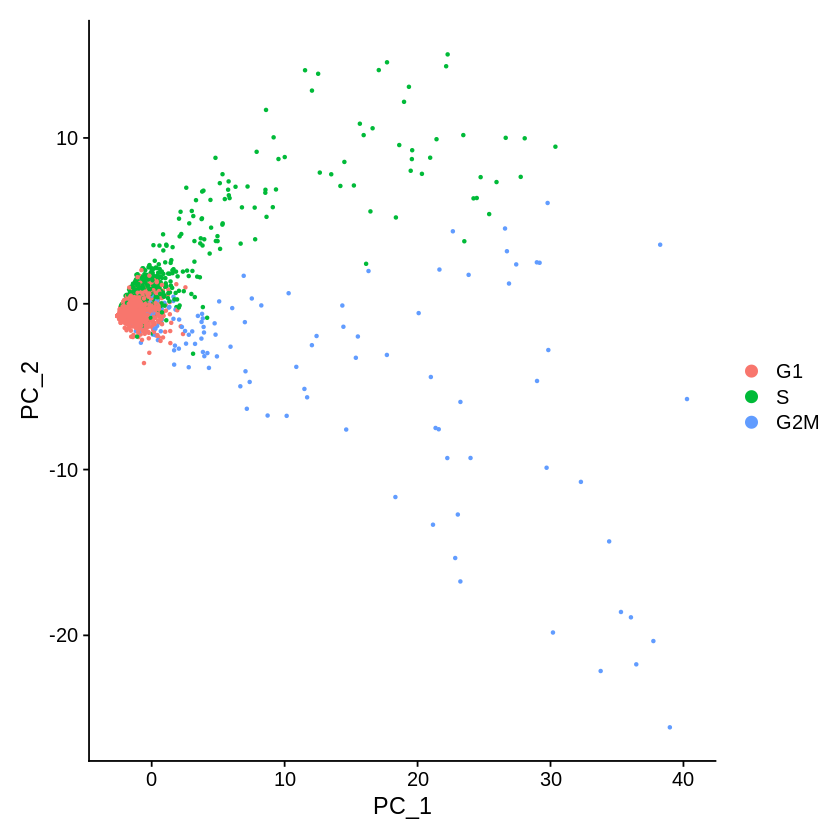

In [26]:
# check cell cycle effect
anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
DimPlot(anndata, reduction = 'pca')

In [27]:
anndataO = anndata
# Regress out cell cycle - NOTE: subset the dataset to speed up process
anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  ALDH1A2, HMGA2, METTL9, HOPX, STRA6, MPPED2, CCNE1, HOXA7, MEIS2, CNTN5 
	   PLAT, NOV, BIRC7, DACH2, GPC3, AC020571.1, STMN1, ASB4, FSCN1, CDH8 
	   HOTAIRM1, PHLDA1, TPM2, CADM1, DDIT4, VAT1L, CPLX1, CKAP2L, COL2A1, TSPAN13 
Negative:  GSTA1, EPHX1, CYB5A, S100A6, INSL3, B2M, APOC1, MIR202HG, PRSS23, S100A16 
	   CYP17A1, CALB2, MSMO1, LDLR, PGRMC1, S100A13, TM7SF2, ASS1, IGFBP7, HMGCS1 
	   SCUBE1, HMGCR, PTCH2, MVD, TGFBR3, IDI1, HSD3B2, SQLE, KLHL4, DIRAS3 
PC_ 2 
Positive:  CYP17A1, CYP11A1, TM7SF2, FDX1, DHCR24, MGST1, INHA, SCARB1, MT3, STAR 
	   FABP3, MT2A, SCD, APOC1, FDPS, CALB2, APOA1, APOE, GRAMD1B, AAMDC 
	   PRDX1, SNCG, DHCR7, GJA1, SCAP, MYL9, MRAP, GSTA4, CYB5R3, LSS 
Negative:  IGFBP4, MMP2, MATN2, COL1A1, WFDC1, CXCL12, BGN, PXDN, MFAP2, LGALS1 
	   OSR1, INHBA, SERPINE2, STC1, COL1A2, SPARCL1, PDGFRA, ISLR, PLAC9, PTCH1 
	   TCF21, DCN, RPL26, PMP22, LHX9, FIBIN, NID1, FBLIM1, HS3ST1, COL5A1 
PC_ 3 
Positive:  SNCG, ALDH1A2, BIRC7, DLK1, HMGA2, M

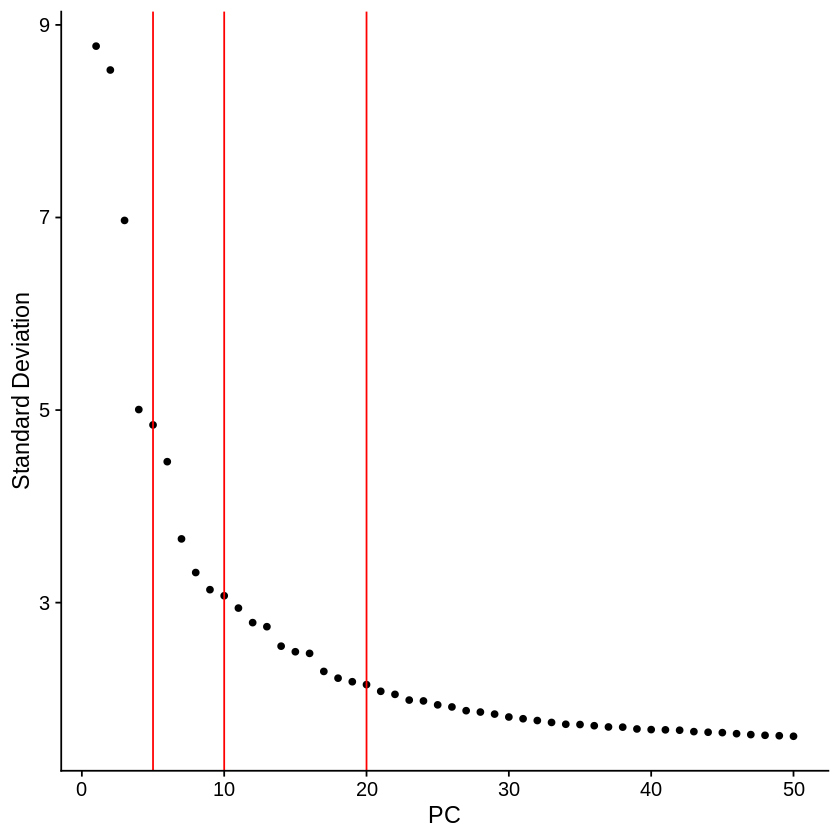

In [28]:
# Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [38]:
npca = 3
# Correct donor's effect on PCA
anndata <- RunHarmony(anndata, group.by.vars = 'individual', dims.use = 1:npca, theta = 1)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [39]:
# Cluster
# anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "pca", verbose = F)
# anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "pca", verbose = F)
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "harmony", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "harmony", verbose = F)

In [58]:
anndata <- FindClusters(anndata, resolution = 0.15)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2618
Number of edges: 68101

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9435
Number of communities: 7
Elapsed time: 0 seconds


In [59]:
# Transfer data
all(rownames(anndataO) == rownames(anndata))
anndataO$seurat_clusters = anndata$seurat_clusters
Idents(anndataO) = Idents(anndata)

anndataO@reductions = anndata@reductions

Warning message in rownames(anndataO) == rownames(anndata):
“longer object length is not a multiple of shorter object length”


[1] FALSE

## Visualize clustering and metadata

Saving 6.67 x 6.67 in image



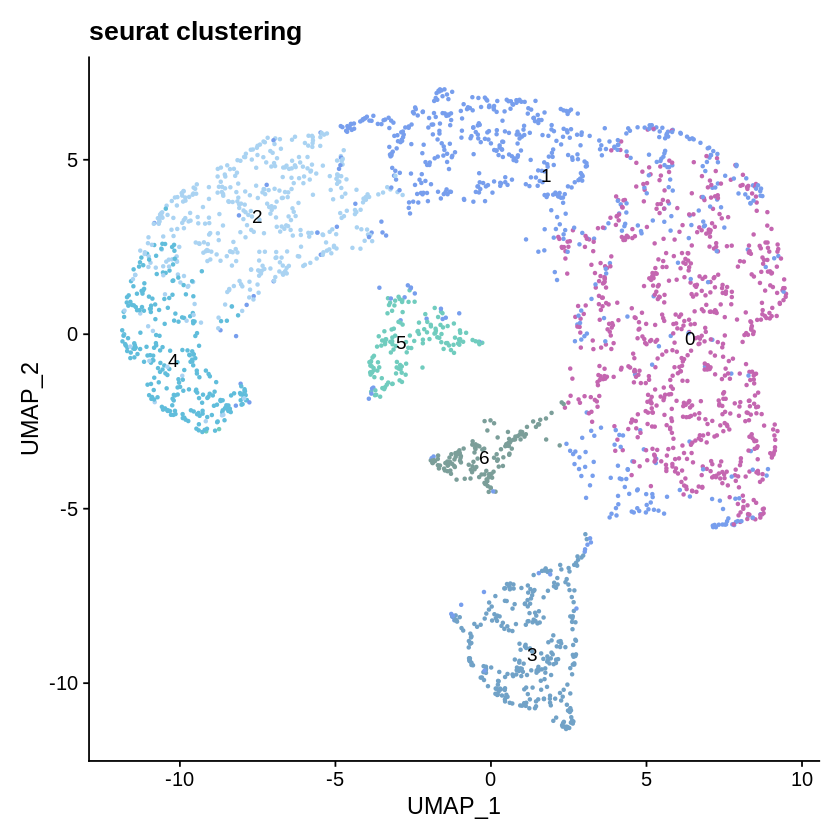

In [60]:
p1 = DimPlot(anndata, reduction = "umap", label = T, cols = colors) + ggtitle('seurat clustering') + NoLegend()
p1
ggsave(filename = paste0('figures-Leydig/umap_clustering.pdf'), dpi = 75)

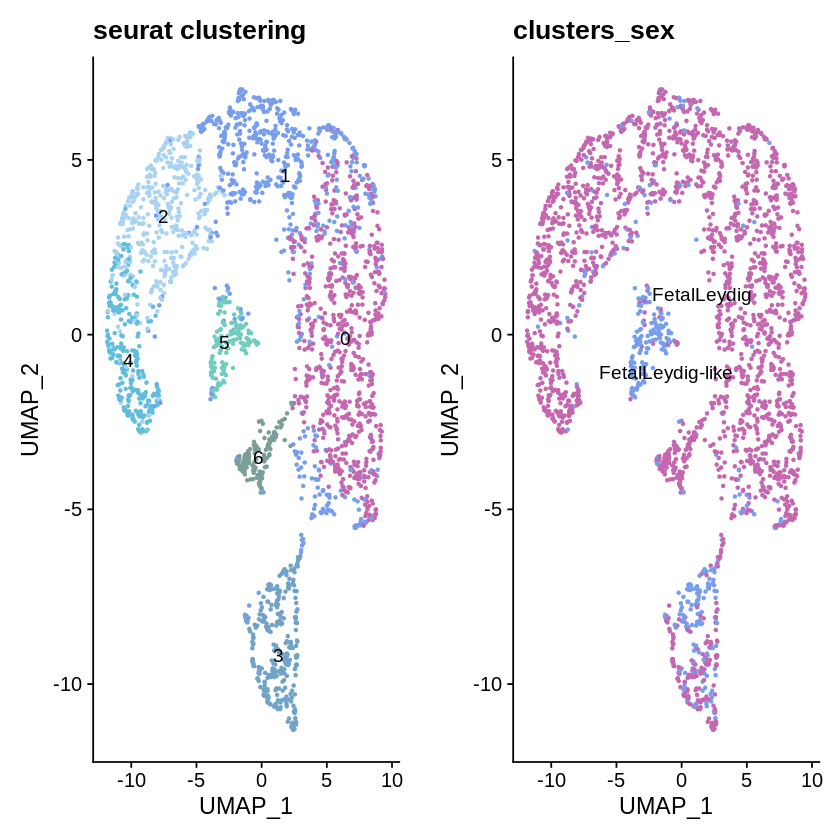

In [61]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'clusters_lineages', label = T, cols = colors) + ggtitle('clusters_sex') + NoLegend()
plot_grid(p1, p1b, ncol = 2)
ggsave(filename = paste0('figures-Leydig/umap_fromSex.pdf'), width = 15, height = 15)

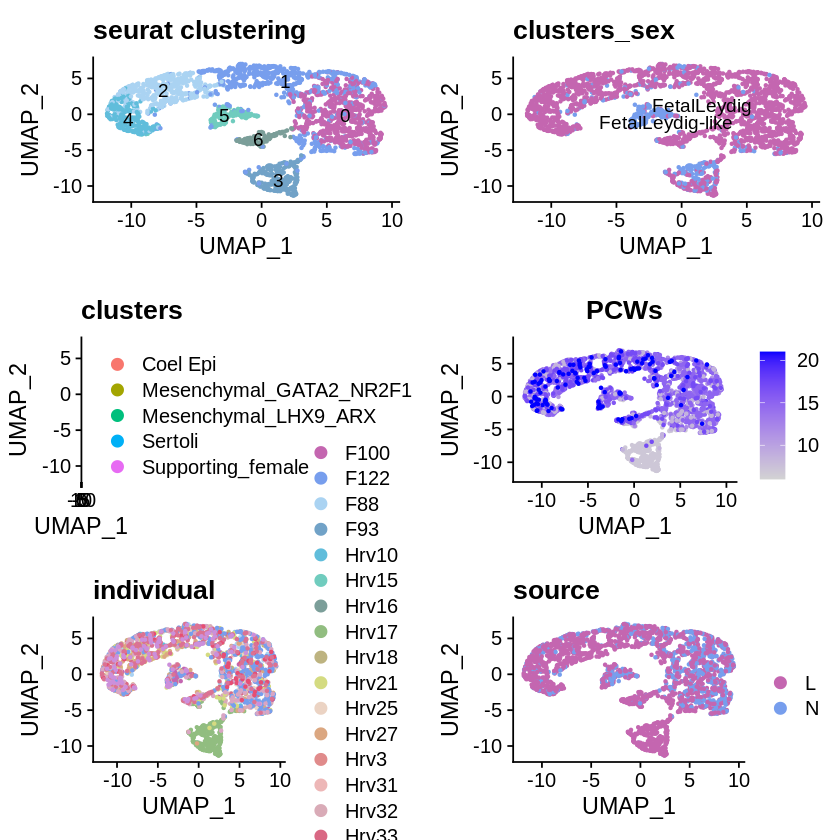

In [62]:
p2 = DimPlot(anndata, reduction = "umap", group.by = 'clusters', label = T) + ggtitle('clusters')
p3 = FeaturePlot(anndata, reduction = "umap", 'PCW') + ggtitle('PCWs')
p4 = DimPlot(anndata, reduction = "umap", group.by = 'individual', cols = colors) + ggtitle('individual')
p5 = DimPlot(anndata, reduction = "umap", group.by = 'sample_source', cols = colors) + ggtitle('source')
p6 = DimPlot(anndata, reduction = "umap", group.by = 'individual', cols = colors) + ggtitle('donor')
plot_grid(p1, p1b, p2, p3, p4, p5, ncol = 2)
ggsave(filename = paste0('figures-Leydig/umap_metadata.pdf'), height = 12, width = 8)

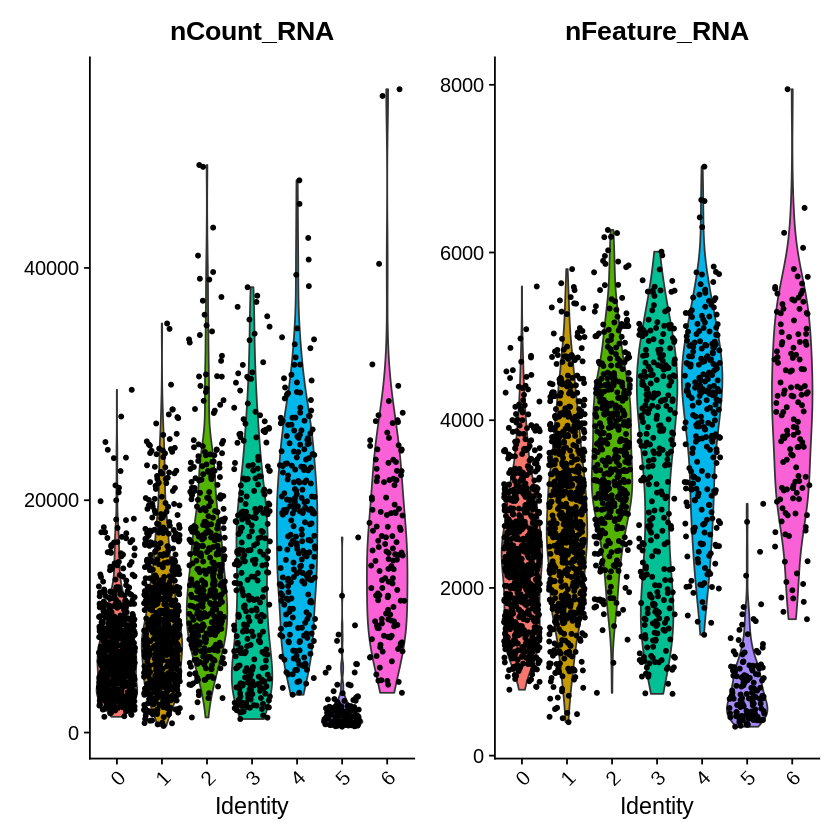

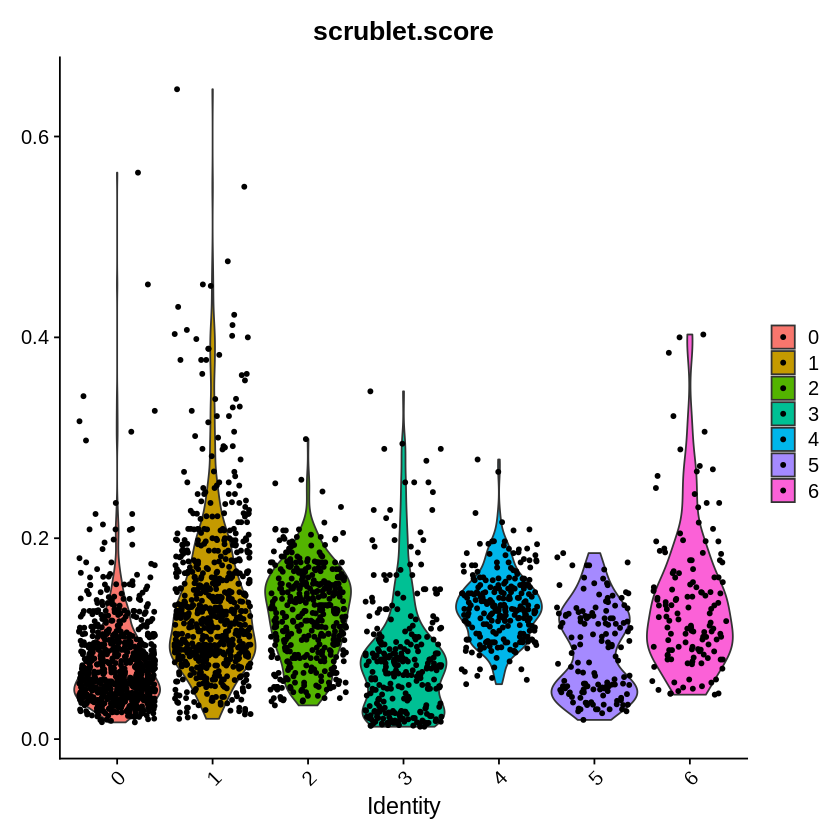

In [63]:
VlnPlot(anndataO, features = c('nCount_RNA', 'nFeature_RNA'))
VlnPlot(anndataO, features = c('scrublet.score'))

## Plot TF-IDF

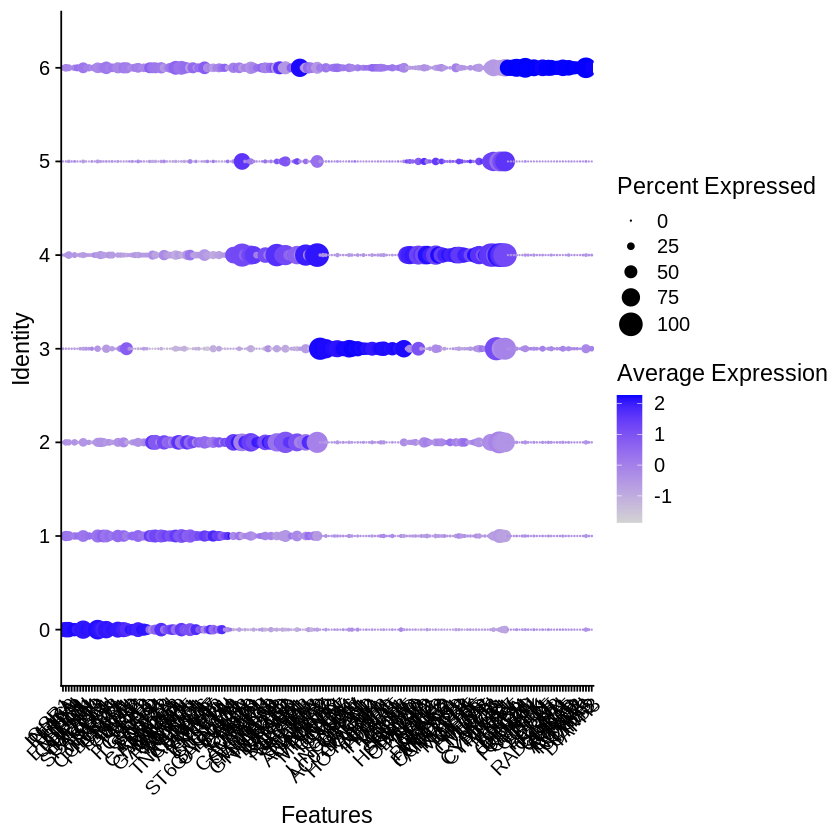

In [64]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 40)
write.csv(df_tfIDF, file = 'figures-Leydig/cluster_markersTFIDF.csv', quote = F, row.names = F)

df_tfIDF$cluster = as.numeric(df_tfIDF$cluster)
df_tfIDF = df_tfIDF[ order(df_tfIDF$cluster), ]
DEGstfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 30L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGstfIDF), group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/dotplot_TFIDF_DEGs.pdf'), dpi = 75, height = 7, width = 35)

## Plot markers

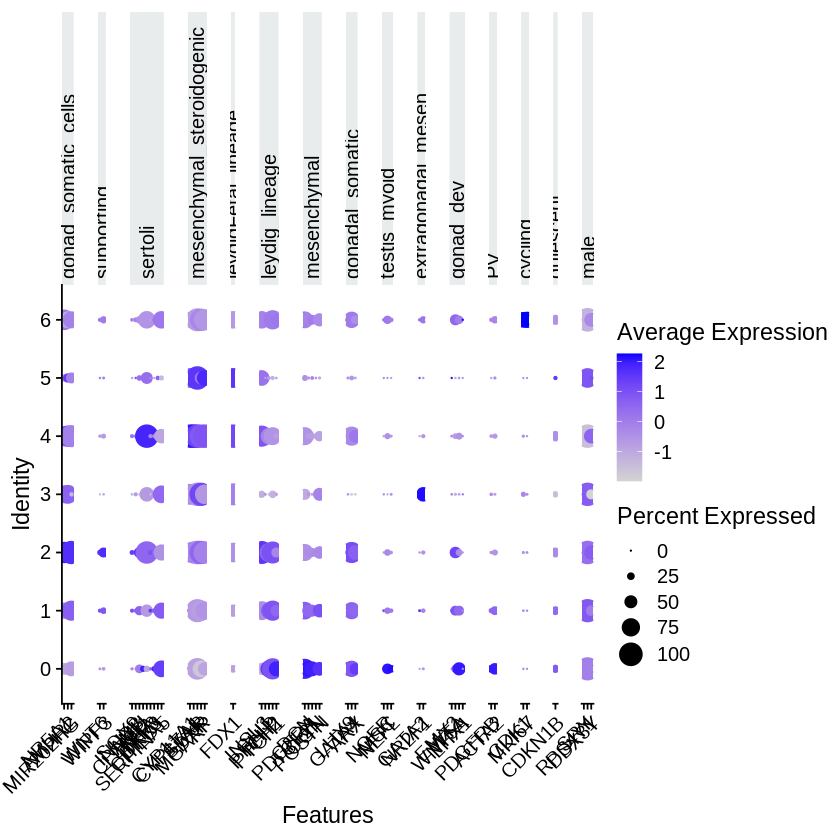

In [65]:
DotPlot(anndataO, features = markers, group.by = 'seurat_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-Leydig/dotplot_markers.pdf'), dpi = 75, height = 7, width = 35)

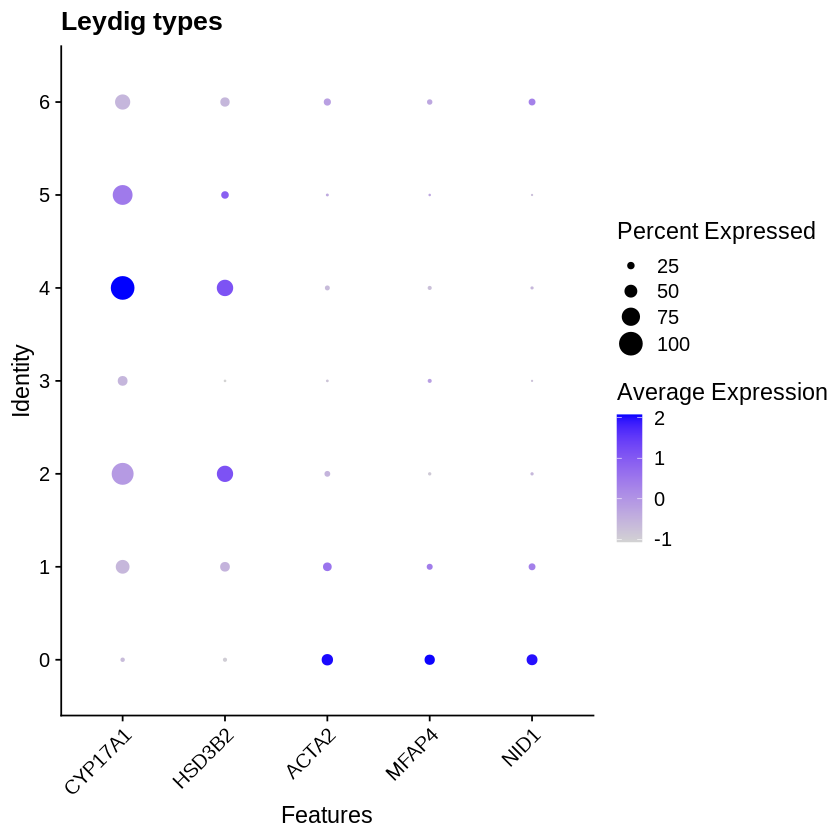

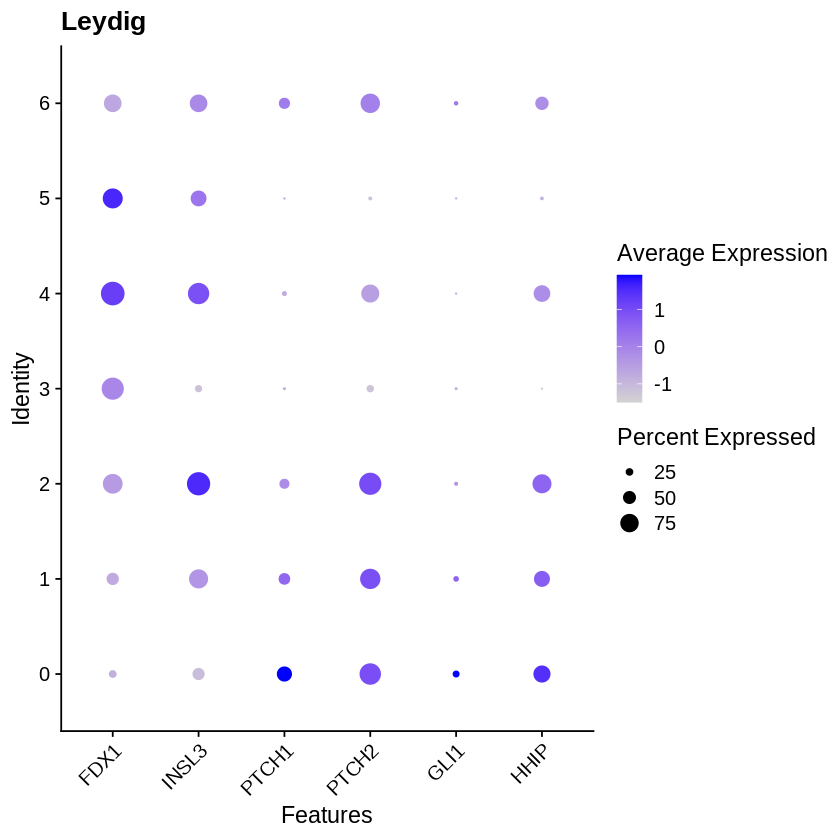

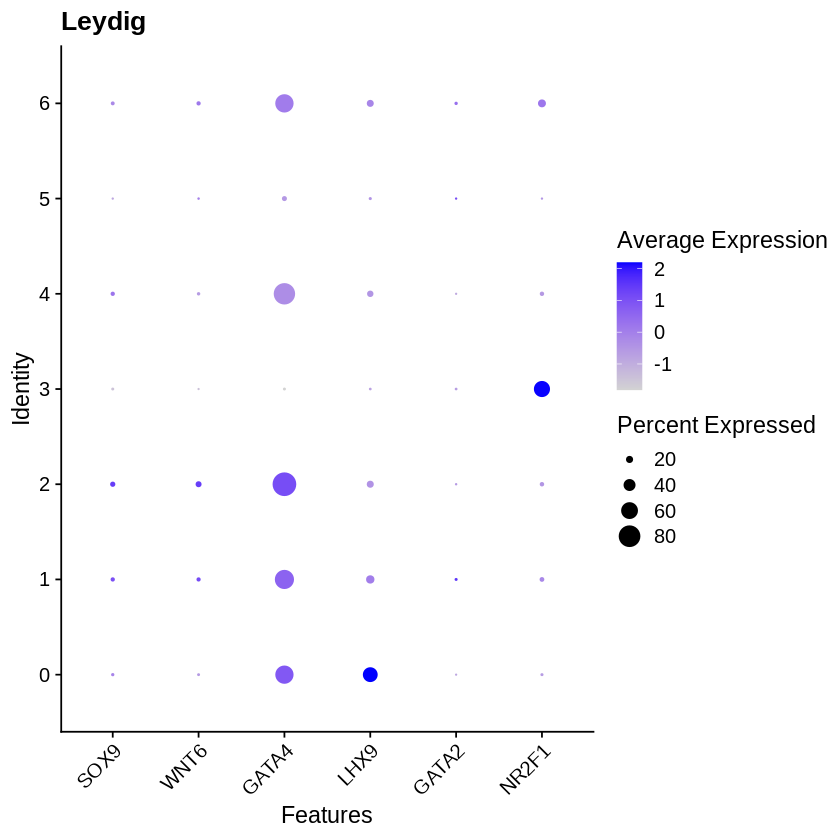

In [66]:
DotPlot(anndataO, features = c('CYP17A1', 'HSD3B2', 'ACTA2', 'MFAP4', 'NID1')) + RotatedAxis() + ggtitle('Leydig types')
DotPlot(anndataO, features = c('FDX1', 'INSL3',  'PTCH1',  'PTCH2', 'GLI1', 'HHIP')) + RotatedAxis() + ggtitle('Leydig')
DotPlot(anndataO, features = c('SOX9', 'WNT6', 'GATA4', 'LHX9', 'GATA2', 'NR2F1')) + RotatedAxis() + ggtitle('Leydig')

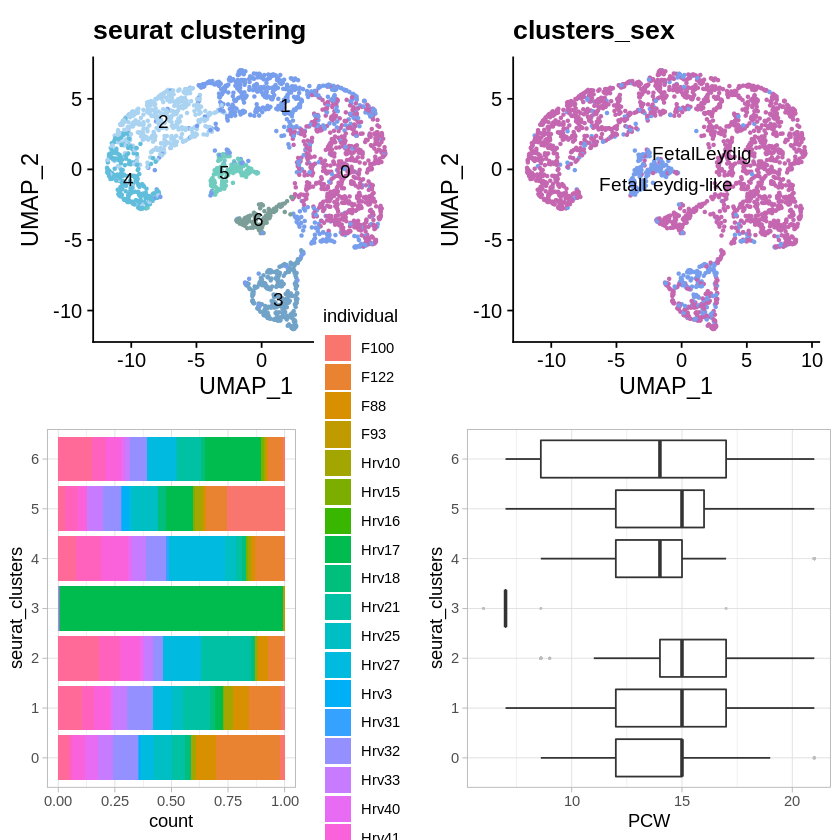

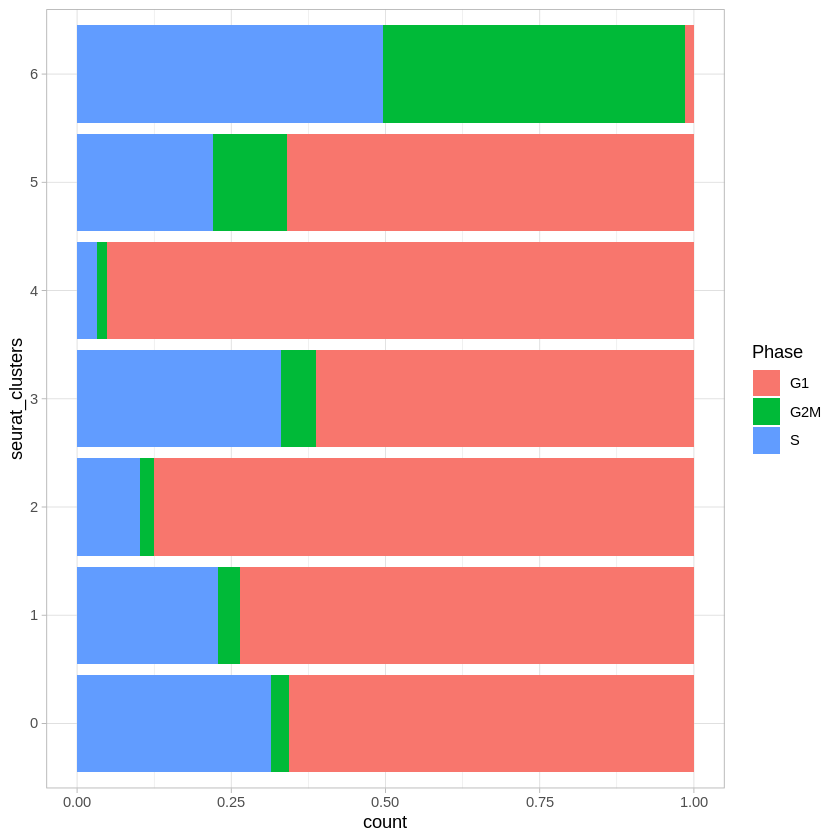

In [67]:
b1 = ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
     theme_light()

b2 = ggplot(anndata@meta.data, aes(x = seurat_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
plot_grid(p1, p1b+ NoLegend(), b1, b2, ncol = 2)
ggsave(filename = paste0('figures-Leydig/metadata.pdf'), dpi = 75, width = 10, height = 10)

ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

## Annotate manually and plot

In [81]:
cluster_names = c('FetalLeydig_ExM',#0
                  'FetalLeydig_Ster',#0
                  'FetalLeydig_Ster',
                  'FetalLeydig_early',
                  'FetalLeydig_Ster',
                  'lowQC',
                  'FetalLeydig_cycling'
)


anndata@meta.data$annotated_clusters = cluster_names[ match(anndata@meta.data$seurat_clusters, 
                                                            as.numeric(levels(anndata@meta.data$seurat_clusters)) ) ]

anndata@meta.data$annotated_clusters = factor(anndata@meta.data$annotated_clusters, levels = c('FetalLeydig_ExM',#0
                  'FetalLeydig_Ster',
                  'FetalLeydig_cycling',
                  'FetalLeydig_early',
                  'lowQC') )

Idents(anndata) = anndata@meta.data$annotated_clusters
anndataO@meta.data$annotated_clusters = anndata@meta.data$annotated_clusters
Idents(anndataO) = anndataO@meta.data$annotated_clusters

Saving 6.67 x 6.67 in image



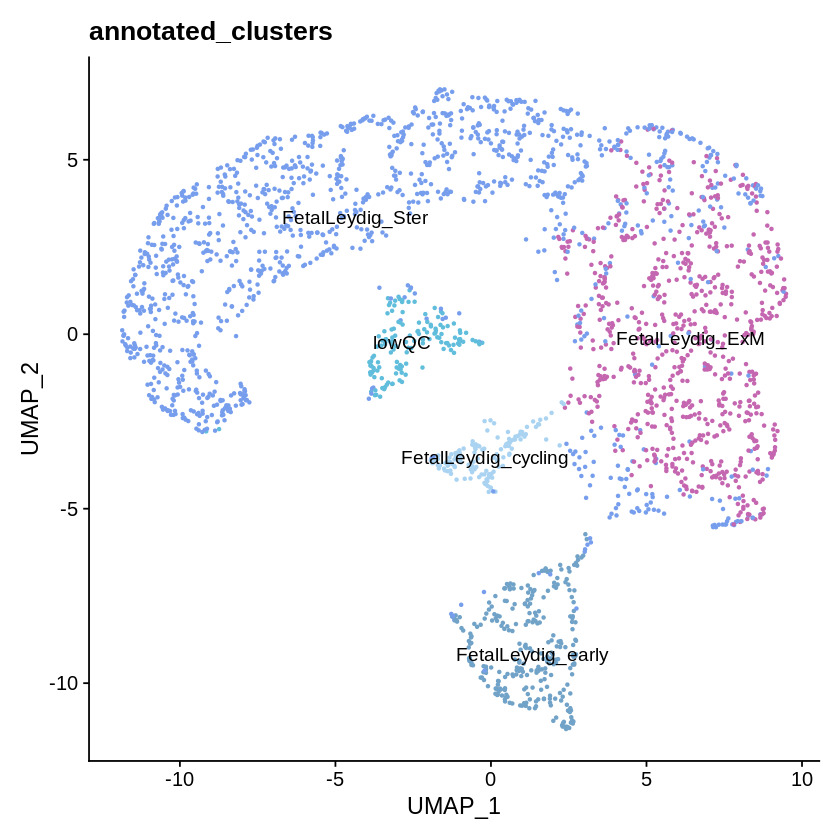

In [82]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, 
             cols = colors ) + ggtitle('annotated_clusters') + NoLegend()
p1b
ggsave(filename = paste0('figures-Leydig/umap_metadata_annotated.pdf'), scale = 1, dpi = 75)

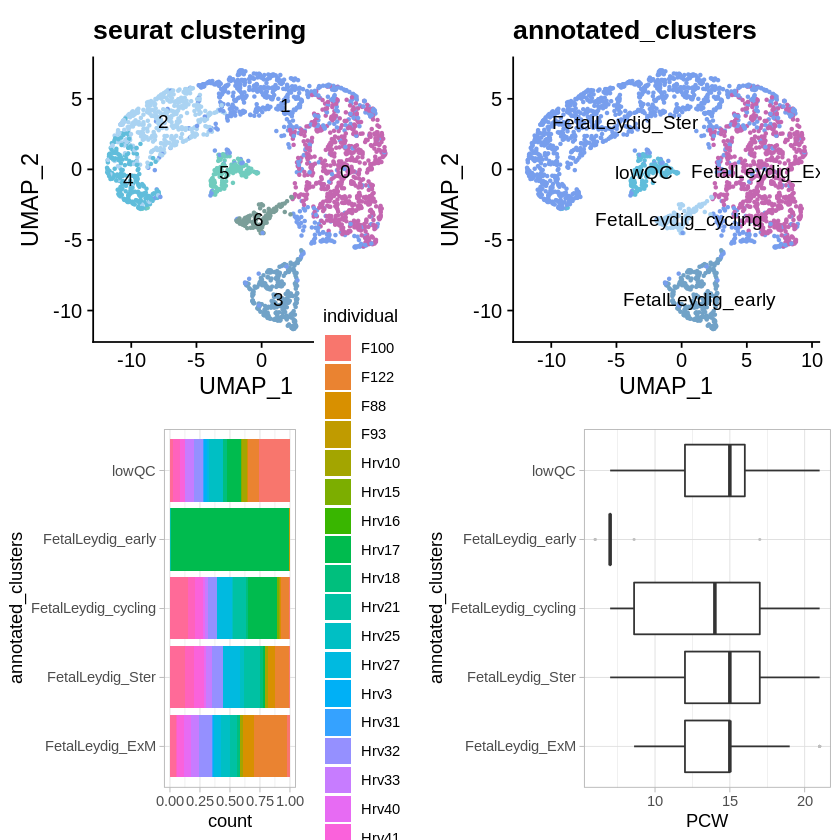

In [83]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
plot_grid(p1, p1b+ NoLegend(), b1, b2, ncol = 2)
ggsave(filename = paste0('figures-Leydig/metadata_annotated.pdf'), dpi = 75, width = 10, height = 10)

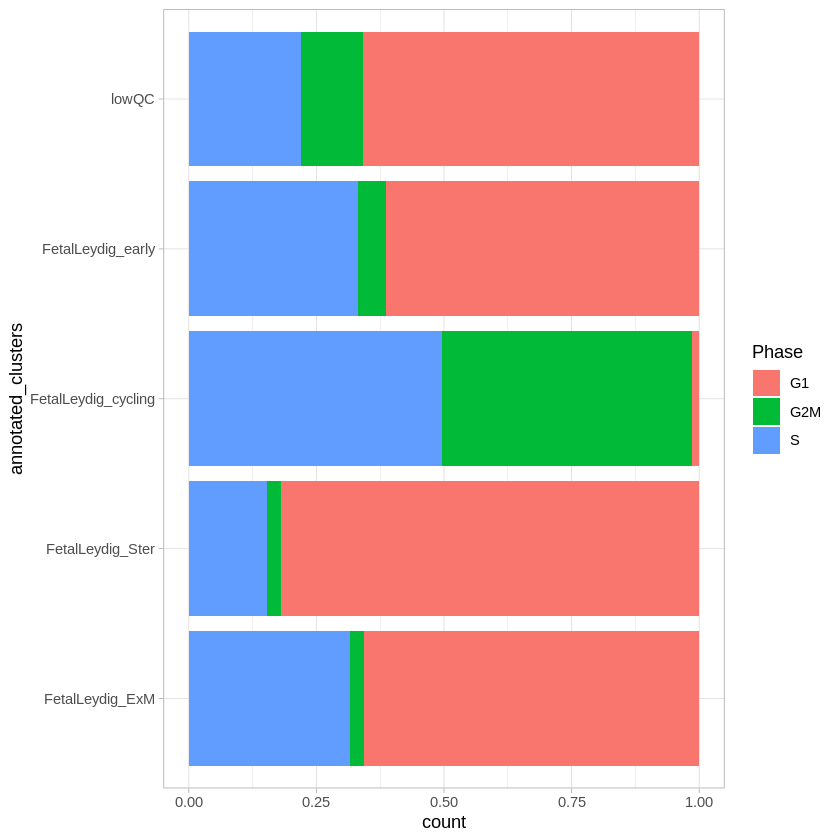

In [84]:
ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

## Save

In [85]:
write.csv(anndataO@meta.data, file = paste0('/nfs/team292/lg18/with_valentina/Leydig_annotated.csv'), quote = F, row.names = T)
saveRDS(anndataO, file = '/nfs/team292/lg18/with_valentina/Leydig.rds')

## Plot global Markers

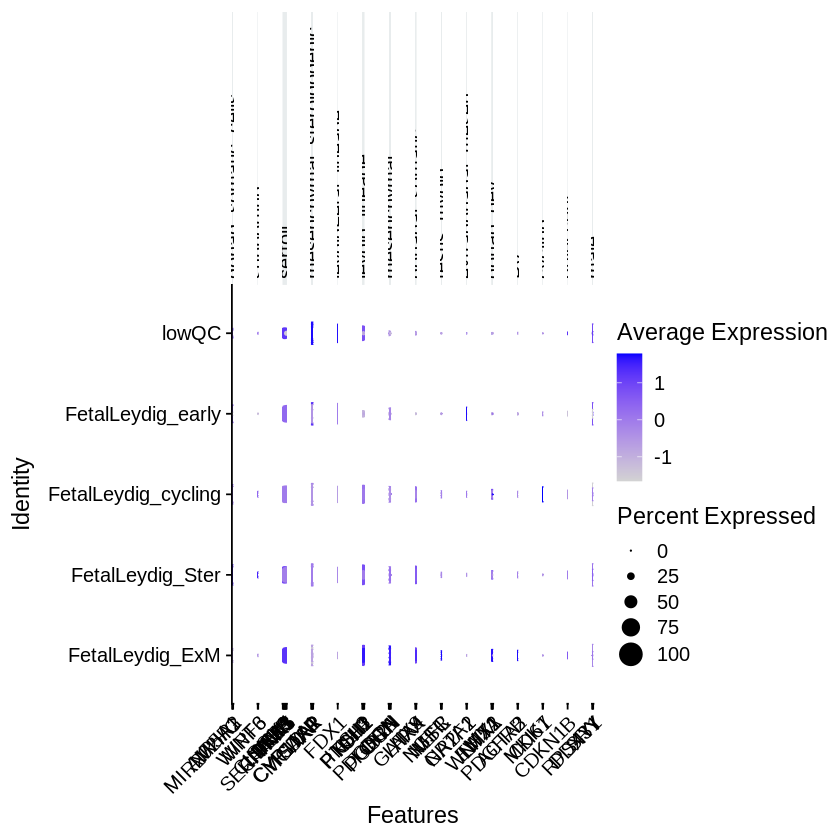

In [86]:
#Replot markers with cluster names
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-Leydig/dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 25)


##  Plot TF-IDF

[1] 407  10

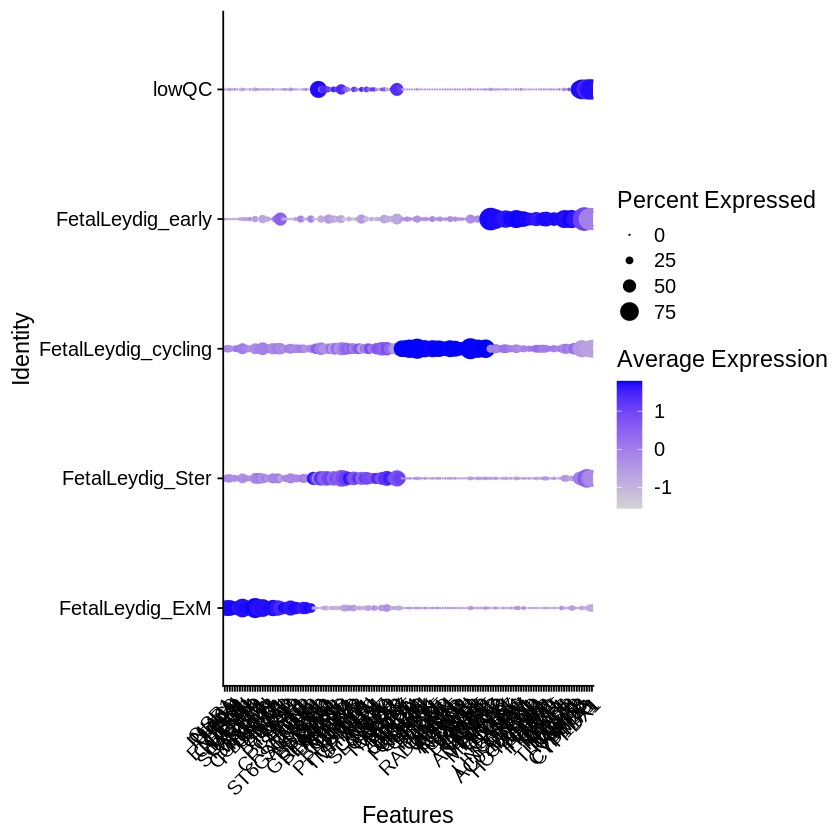

In [87]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
dim(df_tfIDF)
write.csv(df_tfIDF, file = 'figures-Leydig/cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 35L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/dotplot_TFIDF_DEGs_annotated.pdf'), dpi = 75, height = 5, width = 45)

[1] 400  10

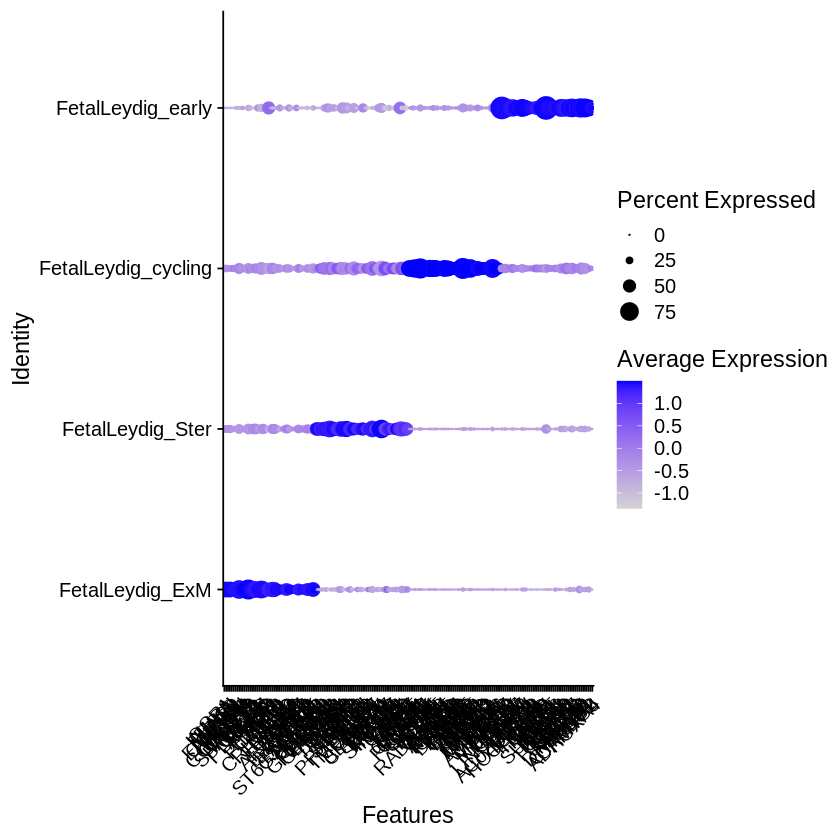

In [88]:
# Remove unwanted
anndataO2 = subset(anndataO, cells = colnames(anndataO)[ ! Idents(anndataO) %in% c('doublet', 'lowQC', 'cont') ] )
df_tfIDF = quickMarkers(toc = anndataO2@assays$RNA@counts, clusters = Idents(anndataO2), N = 100)
dim(df_tfIDF)
write.csv(df_tfIDF, file = 'figures-Leydig/cluster_markersTFIDF_annotatedClean.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO2@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 50L)$gene) %>%
  unlist(.)
DotPlot(anndataO2, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/dotplot_TFIDF_DEGs_annotatedClean.pdf'), dpi = 75, height = 5, width = 25)

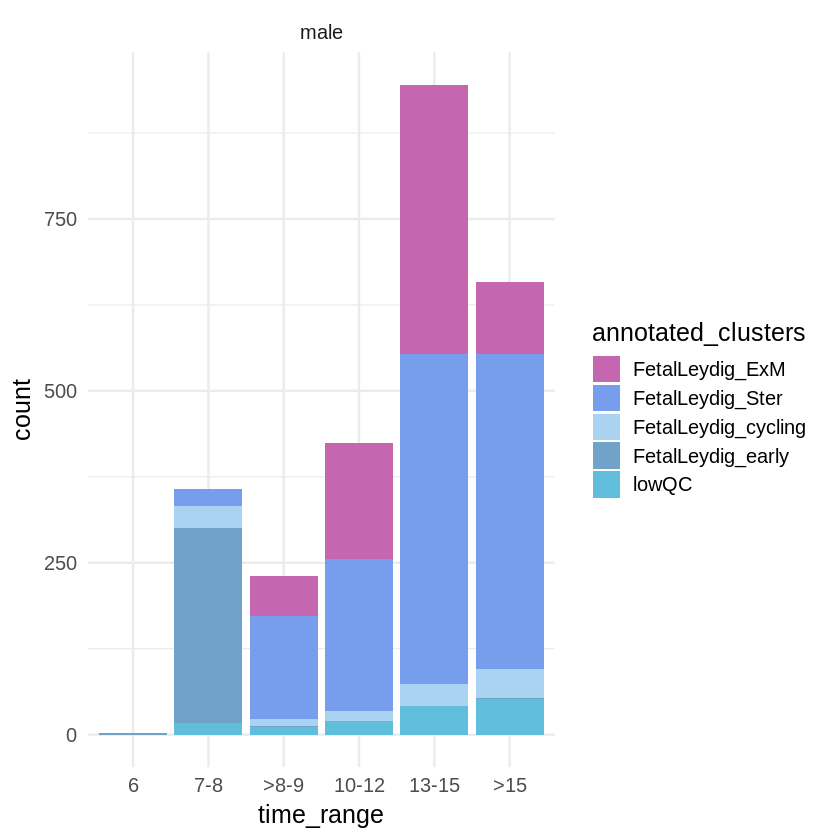

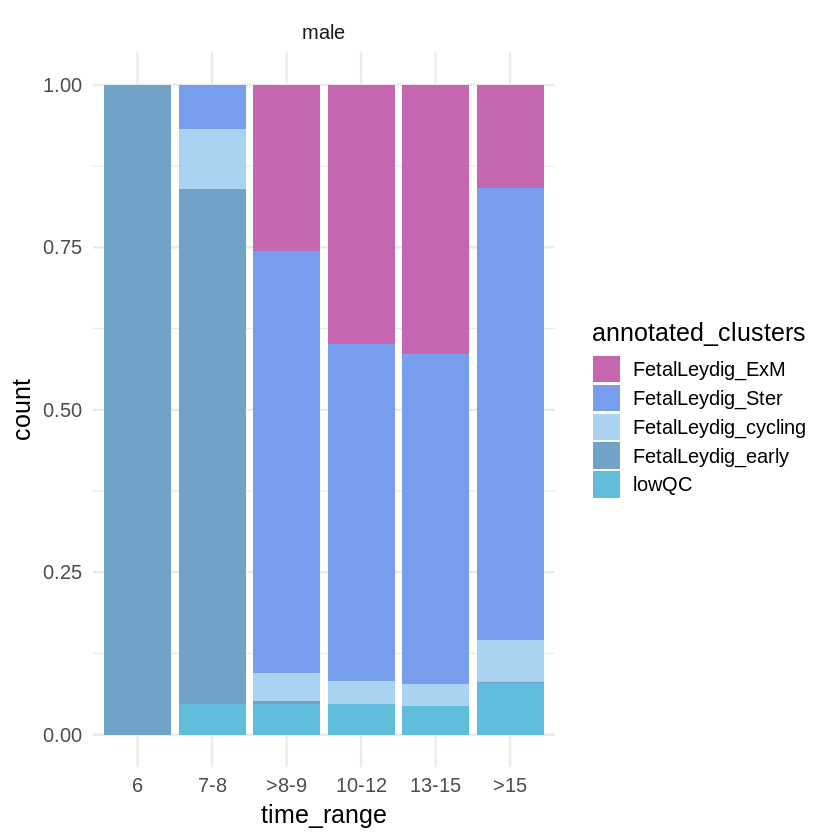

In [89]:
anndataO@meta.data$time_range = '7-8'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW ==6 ] = '6'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 8 ] = '>8-9'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 10 ] = '10-12'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 13 ] = '13-15'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >15 ] = '>15'
anndataO@meta.data$time_range = factor(anndataO@meta.data$time_range, levels = c('6', '7-8', '>8-9', '10-12', '13-15', '>15') )
ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = luz_colors) +
    facet_wrap(~sex)+
#     geom_bar(position = 'fill')+
    geom_bar()+
    theme_minimal(15)
ggsave(filename = paste0('figures-Leydig/barplot_PCWs_sex.pdf'), dpi = 300, width = 9.5, height = 5)

ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = luz_colors) +
    facet_wrap(~sex)+
    geom_bar(position = 'fill')+
    theme_minimal(15)
ggsave(filename = paste0('figures-Leydig/barplot_PCWs_sexII.pdf'), dpi = 300, width = 9.5, height = 5)

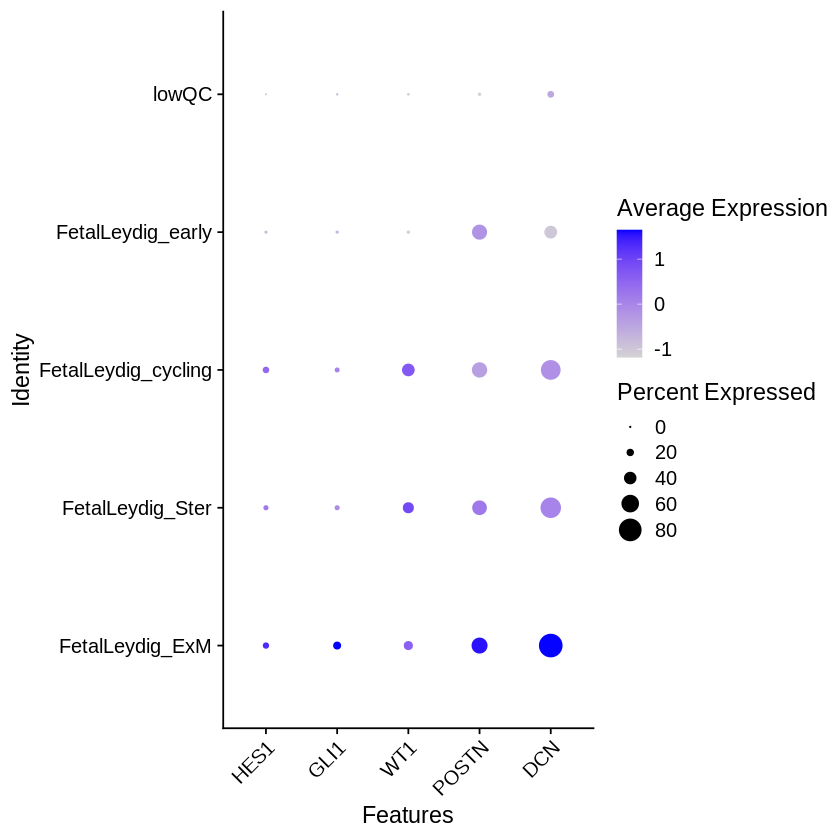

In [90]:
#Replot markers with cluster names
DotPlot(anndataO, features = c('HES1', 'GLI1', 'WT1', 'POSTN', 'DCN'), group.by = 'annotated_clusters') + RotatedAxis() + 
theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))

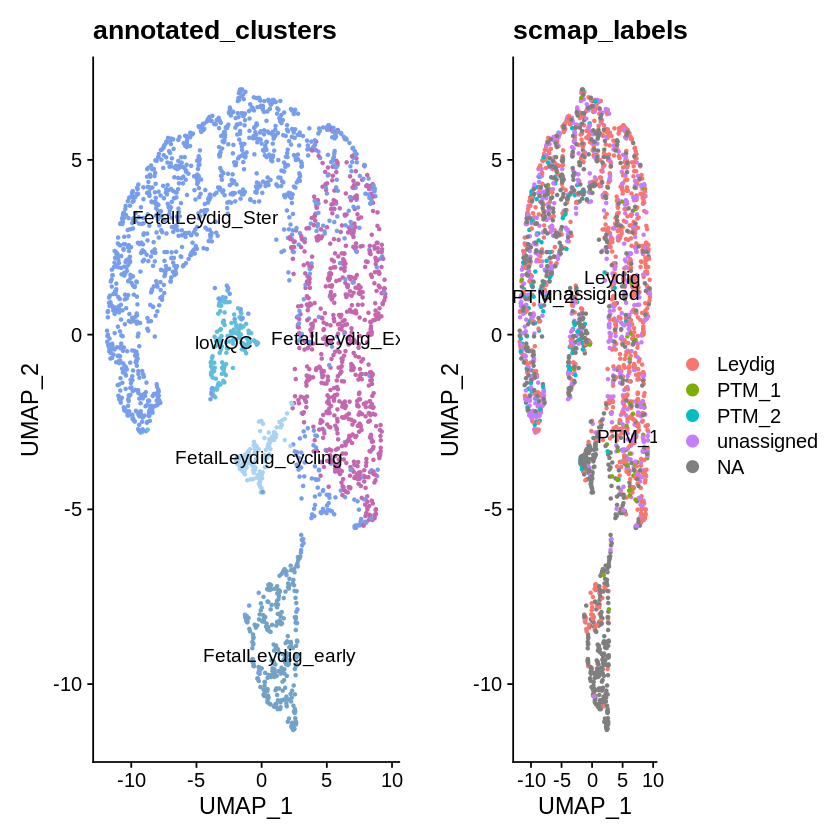

In [91]:
# Add metadata
meta = read.csv('/nfs/team292/lg18/with_valentina/scmap_from_Sonhi2019.csv', stringsAsFactors = F)
names(meta)[1] = 'index'
# meta$scmap_labels[ meta$scmap_similarities < 0.8 ] = 'unassigned'
anndata@meta.data$scmap_labels = meta$scmap_labels[ match(rownames(anndata@meta.data), meta$index) ]

p3 = DimPlot(anndata, reduction = "umap", group.by = 'scmap_labels', label = T) + ggtitle('scmap_labels') 
plot_grid(p1b, p3, ncol = 2)
ggsave(filename = paste0('figures-Leydig/umap_metadata_scmap_labels.pdf'), width = 11, height = 5)

In [92]:
head(meta)

,index,scmap_labels,scmap_similarities
,<chr>,<chr>,<dbl>
1,FCA_GND8289580_AAACGGGAGAAGGACA,PTM_1,0.8234071
2,FCA_GND8289580_AACTCAGAGGGTTCCC,unassigned,0.4439456
3,FCA_GND8289580_AAGACCTCACGGTTTA,Leydig,0.7640938
4,FCA_GND8289580_AAGCCGCAGCCAGGAT,unassigned,0.3814812
5,FCA_GND8289580_AAGCCGCCAAGGTGTG,Leydig,0.8131596
6,FCA_GND8289580_ACACCCTAGTACATGA,Leydig,0.8624967
